# Applied Data Science Capstone - Capitals in Switzerland 

In [ ]:
#!conda install -c conda-forge geocoder 
!pip install geocoder
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
# install wordcloud
#!conda install -c conda-forge wordcloud==1.4.1 --yes
!pip install wordcloud

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import geocoder # import geocoder

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import urllib.request


# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


print('libs imported!')

In [2]:
## settings

# set number of clusters
kclusters = 3

extensions = ('.csv')

countries = ['CH', 'IT']
countries = ['CH']

num_top_venues = 30

cantoni_esclusi =  ('Obwalden', 'Glarus', 'Jura')
cantoni_esclusi =  ()

min_venues = 30


In [3]:
url = 'https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.6.zip'

hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

request=urllib.request.Request(url, None, headers=hdr) #The assembled request

zipfile = ZipFile(BytesIO(urlopen(request).read()))
files_csv = [zipfile.open(file, 'r') for file in zipfile.namelist() if file.endswith(extensions)]
df_capitals = pd.concat([pd.read_csv(file_csv) for file_csv in files_csv])
zipfile.close()

print('\ndf_capitals shape: {}\n'.format(df_capitals.shape))
df_capitals.head()


df_capitals shape: (15493, 11)



,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [4]:

df_ch_it = df_capitals[df_capitals.iso2.isin(countries) & ~df_capitals.admin_name.isin(cantoni_esclusi)]
df_ch_it.reset_index(inplace=True)

#drop population nan
df_ch_it = df_ch_it.dropna(subset=['population'], how='all')

print('\ndf_ch_it shape: {}\n'.format(df_ch_it.shape))
df_city_sorted = df_ch_it[['city', 'country', 'iso2', 'capital', 'population']].sort_values(by='population', ascending=False).head(28)
df_city_sorted


df_ch_it shape: (28, 12)



,city,country,iso2,capital,population
0,Geneva,Switzerland,CH,admin,1240000.0
1,Zürich,Switzerland,CH,admin,1108000.0
3,Basel,Switzerland,CH,admin,830000.0
2,Bern,Switzerland,CH,primary,275329.0
4,Lausanne,Switzerland,CH,admin,265702.0
5,Lucerne,Switzerland,CH,admin,250000.0
6,Lugano,Switzerland,CH,NaN,105388.0
7,Biel/Bienne,Switzerland,CH,NaN,78708.0
8,Sankt Gallen,Switzerland,CH,admin,70572.0
9,Chur,Switzerland,CH,admin,38293.0


### Google geocoder  

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
def geocoder_google(city= 'Geneva', country='Switzerland'):
    
    # initialize your variable to None
    lat_lng_coords = None
    i = 0
    attempts = 3
    
    # loop until you get the coordinates
    while(lat_lng_coords is None and i < attempts):
        address = '{}, {}'.format(city, country)
        g = geocoder.google(address, key=GOOGLE_API_KEY)
        lat_lng_coords = g.latlng
        i = i + 1
        #print('city', city, lat_lng_coords)
    return lat_lng_coords


In [7]:
df_ch_it['Coords'] = df_ch_it.apply(lambda x: geocoder_google(x['city'], x['country']), axis=1)
df_ch_it.head()

,index,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,Coords
0,386,Geneva,Geneva,46.2100,6.140,Switzerland,CH,CHE,Genève,admin,1240000.0,1756810813,"[46.2043907, 6.1431577]"
1,434,Zürich,Zurich,47.3800,8.550,Switzerland,CH,CHE,Zürich,admin,1108000.0,1756539143,"[47.3768866, 8.541694]"
2,547,Bern,Bern,46.9167,7.467,Switzerland,CH,CHE,Bern,primary,275329.0,1756374318,"[46.9479739, 7.4474468]"
3,727,Basel,Basel,47.5804,7.590,Switzerland,CH,CHE,Basel-Stadt,admin,830000.0,1756731313,"[47.5595986, 7.5885761]"
4,1701,Lausanne,Lausanne,46.5304,6.650,Switzerland,CH,CHE,Vaud,admin,265702.0,1756055099,"[46.5196535, 6.6322734]"


In [8]:
lambda_geocoder_google = lambda x: geocoder_google(x['city'], x['country'])
df_city_sorted['coords'] = df_city_sorted.apply(lambda_geocoder_google, axis=1 )
df_city_sorted

,city,country,iso2,capital,population,coords
0,Geneva,Switzerland,CH,admin,1240000.0,"[46.2043907, 6.1431577]"
1,Zürich,Switzerland,CH,admin,1108000.0,"[47.3768866, 8.541694]"
3,Basel,Switzerland,CH,admin,830000.0,"[47.5595986, 7.5885761]"
2,Bern,Switzerland,CH,primary,275329.0,"[46.9479739, 7.4474468]"
4,Lausanne,Switzerland,CH,admin,265702.0,"[46.5196535, 6.6322734]"
5,Lucerne,Switzerland,CH,admin,250000.0,"[47.05016819999999, 8.3093072]"
6,Lugano,Switzerland,CH,NaN,105388.0,"[46.0036778, 8.951051999999999]"
7,Biel/Bienne,Switzerland,CH,NaN,78708.0,"[47.1367785, 7.2467909]"
8,Sankt Gallen,Switzerland,CH,admin,70572.0,"[47.4244818, 9.3767173]"
9,Chur,Switzerland,CH,admin,38293.0,"[46.8507835, 9.5319859]"


### Writing pandas DataFrame to CSV file

In [9]:
df_city_sorted.to_csv('capital-coords.csv', index=False)

In [10]:
df1 = pd.read_csv('capital-coords.csv')

df1.head()

print('capital-coords shape', df1.shape)

capital-coords shape (28, 6)


### Call Foursquare Api to Explore venues

In [11]:
# The code was removed by Watson Studio for sharing.

In [12]:
# explore first n venues near the city, coords=[x, y]
def foursquare_explore_venues(cities, coordinates, radius=500):
    
    venues_list=[]
    for city, coords in zip(cities, coordinates):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            coords[0], 
            coords[1], 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #print('\ncity', city, 'len:', len(results), results)
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            coords[0], 
            coords[1],  
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City Name',
                             'City Latitude',
                             'City Longitude',
                             'Venue',
                             'Venue Latitude', 
                             'Venue Longitude',
                             'Venue Category']
    
    return(nearby_venues)

## List of top venues per city

In [13]:
df_venues = foursquare_explore_venues(df_city_sorted['city'], df_city_sorted['coords'])

#clone original dataframe
df = df_venues[:]

print(df_venues.shape)
df_venues.head()

(1043, 7)


,City Name,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Geneva,46.204391,6.143158,Mövenpick Boutique,46.204839,6.145769,Ice Cream Shop
1,Geneva,46.204391,6.143158,Payot,46.203727,6.144584,Bookstore
2,Geneva,46.204391,6.143158,Brasserie Lipp,46.203286,6.144775,French Restaurant
3,Geneva,46.204391,6.143158,"Rasoi by Vineet at Mandarin Oriental, Geneva",46.205642,6.141429,Indian Restaurant
4,Geneva,46.204391,6.143158,Mandarin Oriental Geneva,46.205611,6.140961,Hotel


In [14]:
## 
#city = df_ch_it[df_ch_it['city'] == 'Appenzell']
#foursquare_explore_venues([city['city'].iloc[0]], [city['Coords'].iloc[0]])

## Let's check how many venues were returned for each city

In [15]:
print('number of distinct city:', len(df_venues['City Name'].unique()))

count = df_venues.groupby('City Name').count()
count.reset_index(inplace=True)
count

number of distinct city: 28


,City Name,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarau,53,53,53,53,53,53
1,Altdorf,5,5,5,5,5,5
2,Appenzell,8,8,8,8,8,8
3,Basel,65,65,65,65,65,65
4,Bellinzona,20,20,20,20,20,20
5,Bern,70,70,70,70,70,70
6,Biel/Bienne,44,44,44,44,44,44
7,Chur,28,28,28,28,28,28
8,Delémont,5,5,5,5,5,5
9,Frauenfeld,16,16,16,16,16,16


In [16]:
# esclude from the list the city with venes less the min_venues 
cities = count[count.Venue > min_venues]['City Name']

df_venues = df_venues[df_venues['City Name'].isin(cities)]

df_venues.head() 

df_venues.groupby('City Name').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City Name,,,,,,
Aarau,53,53,53,53,53,53
Basel,65,65,65,65,65,65
Bern,70,70,70,70,70,70
Biel/Bienne,44,44,44,44,44,44
Geneva,100,100,100,100,100,100
Lausanne,100,100,100,100,100,100
Lucerne,100,100,100,100,100,100
Lugano,54,54,54,54,54,54
Neuchâtel,31,31,31,31,31,31


In [17]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 135 uniques categories.


### Analyze

Calculate the frequency of venues categories for each city

In [18]:
# first two coloumns of the new dataframe will be Postal Code and Borough
df_city = df_venues[['City Name']]

# generate dataframe of dummies venue categories 
df_dummies_venues_categories = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="") 

# concatenate city's column to the dummy venues categories dataframe 
df_analysis = pd.concat([df_city, df_dummies_venues_categories], sort=False, axis=1)

print('df_analysis shape:', df_analysis.shape)
df_analysis.T.head(135)

df_analysis shape: (835, 136)


,0,1,2,3,4,5,6,7,8,9,...,978,979,980,981,982,983,984,985,986,987
City Name,Geneva,Geneva,Geneva,Geneva,Geneva,Geneva,Geneva,Geneva,Geneva,Geneva,...,Solothurn,Solothurn,Solothurn,Solothurn,Solothurn,Solothurn,Solothurn,Solothurn,Solothurn,Solothurn
Accessories Store,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Argentinian Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Art Gallery,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Art Museum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arts & Crafts Store,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asian Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BBQ Joint,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bakery,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by city name and by taking the mean of the frequency of occurrence of each category

In [19]:
df_means_venues_categories = df_analysis.groupby('City Name').mean().reset_index()

print('df_means_venues_categories shape:', df_means_venues_categories.shape)

df_means_venues_categories.T.head(135)

df_means_venues_categories shape: (13, 136)


,0,1,2,3,4,5,6,7,8,9,10,11,12
City Name,Aarau,Basel,Bern,Biel/Bienne,Geneva,Lausanne,Lucerne,Lugano,Neuchâtel,Sankt Gallen,Schaffhausen,Solothurn,Zürich
Accessories Store,0,0,0,0,0.01,0.01,0,0,0,0,0,0,0
American Restaurant,0,0,0,0,0,0.01,0,0,0,0.0212766,0,0,0
Argentinian Restaurant,0,0,0,0,0,0,0,0,0,0,0,0,0.01
Art Gallery,0.0188679,0,0,0,0.01,0,0,0,0,0,0,0,0
Art Museum,0,0,0.0142857,0,0,0,0.01,0,0,0,0,0,0
Arts & Crafts Store,0,0,0,0,0,0,0,0,0,0,0,0,0.01
Asian Restaurant,0.0188679,0,0.0142857,0.0227273,0.01,0,0.05,0,0,0,0,0,0.01
BBQ Joint,0,0,0,0,0,0,0.01,0,0,0,0,0,0
Bakery,0.0188679,0,0.0428571,0.0454545,0,0,0.01,0,0,0.0425532,0.025,0.0645161,0.01


Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [20]:
def get_top_categories_venues(row, num_top_venues):
    return row.iloc[1:].sort_values(ascending=False).index.values[0:num_top_venues]

In [21]:
def get_most_common_venue_columns(groupby_column='City Name', num_top_venues=10):
    
    indicators = ['st', 'nd', 'rd']
    
    # create columns according to number of top venues
    columns = [groupby_column]
    
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    return columns

In [22]:
# create columns according to number of top venues
columns = get_most_common_venue_columns(groupby_column='City Name', num_top_venues=num_top_venues)

# create a new dataframe
df_clustering_venues = pd.DataFrame(columns=columns)
df_clustering_venues['City Name'] = df_means_venues_categories['City Name']

for ind in np.arange(df_means_venues_categories.shape[0]):
    df_clustering_venues.iloc[ind, 1:] = get_top_categories_venues(df_means_venues_categories.iloc[ind, :], num_top_venues)

print('df_clustering_venues shape:', df_clustering_venues.shape)    

print('\ndf_clustering_venues top 5')
df_clustering_venues.T.head()

df_clustering_venues shape: (13, 31)

df_clustering_venues top 5


,0,1,2,3,4,5,6,7,8,9,10,11,12
City Name,Aarau,Basel,Bern,Biel/Bienne,Geneva,Lausanne,Lucerne,Lugano,Neuchâtel,Sankt Gallen,Schaffhausen,Solothurn,Zürich
1st Most Common Venue,Bar,Swiss Restaurant,Café,Café,Bar,Bar,Hotel,Italian Restaurant,Bar,Bar,Hotel,Café,Swiss Restaurant
2nd Most Common Venue,Café,Plaza,Bar,Italian Restaurant,Hotel,French Restaurant,Plaza,Café,Supermarket,Café,Café,Italian Restaurant,Plaza
3rd Most Common Venue,Restaurant,Café,Swiss Restaurant,Bakery,French Restaurant,Italian Restaurant,Swiss Restaurant,Hotel,Plaza,Swiss Restaurant,Supermarket,French Restaurant,Hotel
4th Most Common Venue,Italian Restaurant,Bar,Plaza,Fast Food Restaurant,Italian Restaurant,Burger Joint,Café,Plaza,Pub,Music Venue,Restaurant,Restaurant,Café


In [23]:
### Clustering

In [24]:

# drop the postalCode column and run k-means clustering on dataframe with the venue category frequencies
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_means_venues_categories.drop('City Name', 1))

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 1, 1, 2, 0, 1, 1], dtype=int32)

In [25]:
# add clustering labels
df_clustering_venues = df_clustering_venues.drop(['Cluster Labels'], axis=1, errors='ignore')
df_clustering_venues.insert(0, 'Cluster Labels', kmeans.labels_)

df_merge = df_ch_it[:]
df_merge.rename(columns = {'city' : 'City Name'}, inplace=True)

my_cities = df_city_sorted['city']
df_merge = df_merge[df_merge['City Name'].isin(my_cities)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each postal code
df_merged = df_merge.join(df_clustering_venues.set_index('City Name'), on='City Name', how='inner')

print('df_merged shape:', df_merged.shape)
df_merged.head().T # check the last columns!

df_merged shape: (13, 44)


,0,1,2,3,4
index,386,434,547,727,1701
City Name,Geneva,Zürich,Bern,Basel,Lausanne
city_ascii,Geneva,Zurich,Bern,Basel,Lausanne
lat,46.21,47.38,46.9167,47.5804,46.5304
lng,6.14,8.55,7.467,7.59,6.65
country,Switzerland,Switzerland,Switzerland,Switzerland,Switzerland
iso2,CH,CH,CH,CH,CH
iso3,CHE,CHE,CHE,CHE,CHE
admin_name,Genève,Zürich,Bern,Basel-Stadt,Vaud
capital,admin,admin,primary,admin,admin


In [26]:
# create map
location=[df_merged.mean()['lat'], df_merged.mean()['lng']]
map_clusters = folium.Map(location=location, zoom_start=6.5).add_to(folium.Figure(width=800, height=400))

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['lat'], df_merged['lng'], df_merged['City Name'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon]
        , radius=5
        , popup=label
        , color=rainbow[cluster-1]
        , fill=True
        , fill_color=rainbow[cluster-1]
        , fill_opacity=0.9
    ).add_to(map_clusters)
       
map_clusters

## Examin Clusters

Based on the defining categories, we will assign a label to each cluster.

In [27]:
# get cluster
def get_cluster(df, cluster_label):
    return df.loc[df['Cluster Labels'] == cluster_label, df.columns[list(range(0, 3)) + list(range(5, df.shape[1]))]]

#    return df.loc[df['Cluster Labels'] == cluster_label, df.columns[[1] + list(range(5, df.shape[1]))]]

### Cluster 1 - red label



In [28]:
cluster1 = get_cluster(df_merged, 0)
cluster1.T

,6,13
index,3171,4821
City Name,Lugano,Solothurn
city_ascii,Lugano,Solothurn
country,Switzerland,Switzerland
iso2,CH,CH
iso3,CHE,CHE
admin_name,Ticino,Solothurn
capital,NaN,NaN
population,105388,14853
id,1756503816,1756021237


### Cluster 2 - red label



In [29]:
cluster2 = get_cluster(df_merged, 1)
cluster2.T

,0,4,8,11
index,386,1701,3594,4313
City Name,Geneva,Lausanne,Sankt Gallen,Neuchâtel
city_ascii,Geneva,Lausanne,Sankt Gallen,Neuchatel
country,Switzerland,Switzerland,Switzerland,Switzerland
iso2,CH,CH,CH,CH
iso3,CHE,CHE,CHE,CHE
admin_name,Genève,Vaud,Sankt Gallen,Neuchâtel
capital,admin,admin,admin,admin
population,1.24e+06,265702,70572,31270
id,1756810813,1756055099,1756343098,1756726571


### Cluster 3 - red label



In [30]:
cluster3 = get_cluster(df_merged, 2)
cluster3.T

,1,2,3,5,7,25,29
index,434,547,727,1784,3502,8590,10572
City Name,Zürich,Bern,Basel,Lucerne,Biel/Bienne,Schaffhausen,Aarau
city_ascii,Zurich,Bern,Basel,Lucerne,Biel/Bienne,Schaffhausen,Aarau
country,Switzerland,Switzerland,Switzerland,Switzerland,Switzerland,Switzerland,Switzerland
iso2,CH,CH,CH,CH,CH,CH,CH
iso3,CHE,CHE,CHE,CHE,CHE,CHE,CHE
admin_name,Zürich,Bern,Basel-Stadt,Luzern,Bern,Schaffhausen,Aargau
capital,admin,primary,admin,admin,NaN,NaN,NaN
population,1.108e+06,275329,830000,250000,78708,33863,15501
id,1756539143,1756374318,1756731313,1756544536,1756649723,1756003651,1756007454


## concatenates in one string all the categories of the extracted venues for a set of cities

In [33]:
def get_cluster_words (df, cities):
    cluster_words = ''   
    for index, row  in df[df['City Name'].isin(cities)][['City Name', 'Venue Category']] .iterrows():
        cluster_words = cluster_words + ' ' + row['City Name'] + ' ' + row['Venue Category']
    return cluster_words

In [34]:
def get_cluster_words2 (df, cities):
    cluster_words = ''   
    for index, row  in df[df['City Name'].isin(cities)][['City Name', 'Venue Category']] .iterrows():
        cluster_words = cluster_words + ' ' + row['Venue Category']
    return cluster_words

In [35]:
cluster_words1 = get_cluster_words(df_venues, cluster1['City Name'])
cluster_words2 = get_cluster_words(df_venues, cluster2['City Name'])
cluster_words3 = get_cluster_words(df_venues, cluster3['City Name'])

cluster_words4 = get_cluster_words2(df_venues, cluster1['City Name'])
cluster_words5 = get_cluster_words2(df_venues, cluster2['City Name'])
cluster_words6 = get_cluster_words2(df_venues, cluster3['City Name'])


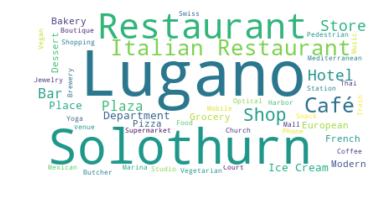

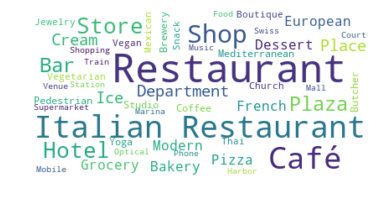

In [36]:

stopwords = set(STOPWORDS)
# instantiate a word cloud object
cluster_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
cluster_wc.generate(cluster_words1)

# display the word cloud
plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# generate the word cloud
cluster_wc.generate(cluster_words4)

# display the word cloud
plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

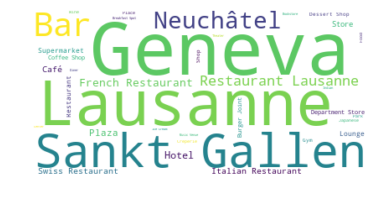

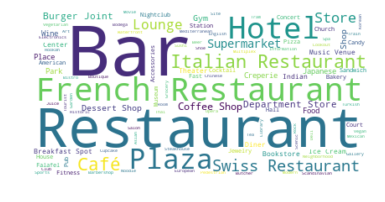

In [37]:
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
# instantiate a word cloud object
cluster_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
cluster_wc.generate(cluster_words2)

# display the word cloud
plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# generate the word cloud
cluster_wc.generate(cluster_words5)

# display the word cloud
plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

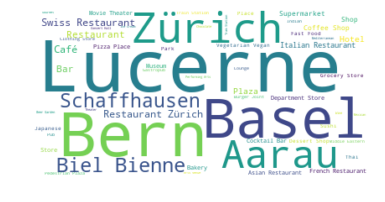

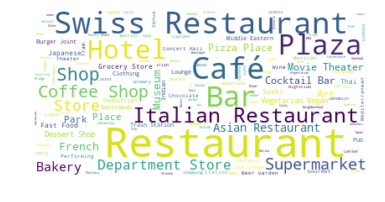

In [38]:
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
# instantiate a word cloud object
cluster_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
cluster_wc.generate(cluster_words3)

# display the word cloud
plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# generate the word cloud
cluster_wc.generate(cluster_words6)

# display the word cloud
plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')
plt.show()